In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [66]:
df = pd.read_csv("milling_manufacturing.csv")

In [67]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [68]:
import random

# Set the seed for reproducibility
random.seed(0)  # You can use any integer value as the seed

number_filter = 800

# Generate 1000 random integers between 1 and 10000
df = df.iloc[random.sample(range(1, 10001), number_filter),:]
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
6312,6313,M21172,M,300.9,310.2,1533,38.1,137,0,0,0,0,0,0
6891,6892,L54071,L,300.9,311.5,1505,41.1,129,0,0,0,0,0,0
664,665,L47844,L,297.5,308.9,1390,47.4,187,0,0,0,0,0,0
4243,4244,M19103,M,302.4,310.9,1435,42.3,83,0,0,0,0,0,0
8377,8378,L55557,L,298.8,309.7,1336,50.3,44,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,3062,L50241,L,300.1,309.1,1353,58.7,86,0,0,0,0,0,0
7277,7278,L54457,L,300.1,310.2,1475,54.2,53,0,0,0,0,0,0
5721,5722,M20581,M,302.3,311.8,1443,43.4,175,0,0,0,0,0,0
6372,6373,M21232,M,300.0,309.5,1879,22.4,79,0,0,0,0,0,0


In [69]:
Temp = {
   "(7.6C , 9.4C)"   : 0.1,
   "(9.4C , 10.7C)"  : 0.3,
   "(10.7C , 12.1C)" : 0.5
}

Rotation= {
   "(1167rpm , 1449rpm)"    : 0.1,
   "(1449.0rpm , 1568rpm)"  : 0.3,
   "(1568.0rpm , 2886rpm)"  : 0.5
}

Torque = {
   "(3.799Nm, 35.8Nm)" : 0.1,
   "(35.8Nm, 44.4Nm)"  : 0.3,
   "(44.4Nm, 76.6Nm)"  : 0.5
}

Tool_wear = {
   "H" : 5,
   "M" : 3,
   "L" : 2
}

Failure, F_dt = gp.multidict({
   "HDF" : 10,
   "PWF" : 5,
   "OSF" : 3,
   "TWF" : 12
})

quality_ratio, ratio = gp.multidict({
   "H" : 0.2,
   "M" : 0.3,
   "L" : 0.5
})

# total time
num_month = 6
num_days_in_month = 30
hrs = 16
min = 60
Total_time = num_month*num_days_in_month*hrs*min 

# number of failure occer during the whole time
Total_failure = 5000

# number of product need to produce atleast
Total_product = 1200

# for each product after assigned, the min and max size
Minimun_produced = 1
Maxumim_produced = 100

Product_type_ratio = 0.98

In [70]:
temp_diff = (df["Process temperature [K]"] - df["Air temperature [K]"])
df["temp_level"] = pd.qcut(temp_diff, q=3, labels =[
    "(7.6C , 9.4C)",
    "(9.4C , 10.7C)" ,
    "(10.7C , 12.1C)"
   ])

In [71]:
df["Rotational_level"] = pd.qcut(df['Rotational speed [rpm]'], q=3,labels =[
   "(1167rpm , 1449rpm)",    
   "(1449.0rpm , 1568rpm)",
   "(1568.0rpm , 2886rpm)" 
   ])

In [72]:
df["Torque_level"] = pd.qcut(df['Torque [Nm]'], q=3,labels =[
   "(3.799Nm, 35.8Nm)",
   "(35.8Nm, 44.4Nm)" ,
   "(44.4Nm, 76.6Nm)" 
   ])

In [73]:
df[["temp_level","Rotational_level","Torque_level"]]

,temp_level,Rotational_level,Torque_level
6312,"(7.6C , 9.4C)","(1449.0rpm , 1568rpm)","(35.8Nm, 44.4Nm)"
6891,"(9.4C , 10.7C)","(1449.0rpm , 1568rpm)","(35.8Nm, 44.4Nm)"
664,"(10.7C , 12.1C)","(1167rpm , 1449rpm)","(44.4Nm, 76.6Nm)"
4243,"(7.6C , 9.4C)","(1167rpm , 1449rpm)","(35.8Nm, 44.4Nm)"
8377,"(10.7C , 12.1C)","(1167rpm , 1449rpm)","(44.4Nm, 76.6Nm)"
...,...,...,...
3061,"(7.6C , 9.4C)","(1167rpm , 1449rpm)","(44.4Nm, 76.6Nm)"
7277,"(9.4C , 10.7C)","(1449.0rpm , 1568rpm)","(44.4Nm, 76.6Nm)"
5721,"(7.6C , 9.4C)","(1167rpm , 1449rpm)","(35.8Nm, 44.4Nm)"
6372,"(7.6C , 9.4C)","(1568.0rpm , 2886rpm)","(3.799Nm, 35.8Nm)"


In [74]:
# Apply the mappings to the DataFrame
df['temp_weight'] = df['temp_level'].map(Temp)
df['rotation_weight'] = df['Rotational_level'].map(Rotation)
df['torque_weight'] = df['Torque_level'].map(Torque)    

# Create the final dictionary
cooldown = {}
for idx, row in df.iterrows():
    cooldown[idx + 1] = (row['temp_weight'], row['rotation_weight'], row['torque_weight'])

# Display the first 5 items
print("--------------cooldown-------------")
for key, value in list(cooldown.items())[:5]:
    print(f'{key}: {value}')

--------------cooldown-------------
6313: (0.1, 0.3, 0.3)
6892: (0.3, 0.3, 0.3)
665: (0.5, 0.1, 0.5)
4244: (0.1, 0.1, 0.3)
8378: (0.5, 0.1, 0.5)


In [75]:
H = {k+1: v for k, v in df["HDF"].to_dict().items()}
P = {k+1: v for k, v in df["PWF"].to_dict().items()}
O = {k+1: v for k, v in df["OSF"].to_dict().items()}

# Display the first 5 items
print("--------------HDF-------------")
for key, value in list(H.items())[:5]:
    print(f'{key}: {value}')
    # Display the first 5 items
print("--------------PWF-------------")
for key, value in list(P.items())[:5]:
    print(f'{key}: {value}')
    # Display the first 5 items
print("--------------OSF-------------")
for key, value in list(O.items())[:5]:
    print(f'{key}: {value}')

--------------HDF-------------
6313: 0
6892: 0
665: 0
4244: 0
8378: 0
--------------PWF-------------
6313: 0
6892: 0
665: 0
4244: 0
8378: 0
--------------OSF-------------
6313: 0
6892: 0
665: 0
4244: 0
8378: 0


In [76]:
df['tool_wear_weight'] = df["Type"].map(Tool_wear)

# Create the final dictionary
W = {}
for idx, row in df.iterrows():
    W[idx + 1] = (row['tool_wear_weight'])

print("--------------tool_wear-------------")
for key, value in list(W.items())[:5]:
    print(f'{key}: {value}')

--------------tool_wear-------------
6313: 3
6892: 2
665: 2
4244: 3
8378: 2


# Model

In [77]:
mMilling = gp.Model('Milling')

numberProd = mMilling.addVars(cooldown.keys(), vtype='I', name='numberProd') 
assign = mMilling.addVars(cooldown.keys(), vtype='B', name='assign') 

# Objective function
TotDT = gp.quicksum(sum(cooldown[i])*numberProd[i] + \
                    H[i]*numberProd[i]*F_dt["HDF"] + \
                       P[i]*numberProd[i]*F_dt["PWF"] + \
                         O[i]*numberProd[i]*F_dt["OSF"] +\
                            W[i]*numberProd[i]*F_dt["TWF"]/200 for i in cooldown.keys())

mMilling.setObjective(TotDT, GRB.MINIMIZE)

L_list = [i for i, v in W.items() if v == 2]
M_list = [i for i, v in W.items() if v == 3]
H_list = [i for i, v in W.items() if v == 5]
# Constraint functions
mMilling.addConstr(
        gp.quicksum(numberProd[i] for i in L_list) \
                == ratio["L"]*gp.quicksum(numberProd[i] for i in cooldown.keys()),
        name="Total L"
)

mMilling.addConstr(
        gp.quicksum(numberProd[i] for i in M_list) \
                == ratio["M"]*gp.quicksum(numberProd[i] for i in cooldown.keys()),
        name="Total M"
)

mMilling.addConstr(
        gp.quicksum(numberProd[i] for i in H_list) \
                == ratio["H"]*gp.quicksum(numberProd[i] for i in cooldown.keys()),
        name="Total H"
)

mMilling.addConstr(
        (gp.quicksum(W[i]*numberProd[i] for i in cooldown.keys()) +\
                gp.quicksum(sum(cooldown[i])*numberProd[i] + \
                    H[i]*numberProd[i]*F_dt["HDF"] + \
                       P[i]*numberProd[i]*F_dt["PWF"] + \
                         O[i]*numberProd[i]*F_dt["OSF"] +\
                            W[i]*numberProd[i]*F_dt["TWF"]/200 for i in cooldown.keys())
                        ) == [Total_time-1000,Total_time],
        name="Total Time"
)

mMilling.addConstr(
        gp.quicksum( (H[i]+P[i]+O[i])*numberProd[i]+\
                            W[i]*numberProd[i]/200 for i in cooldown.keys())
                        <= Total_failure,
        name="Total Failure"
)

mMilling.addConstr(
        gp.quicksum( numberProd[i] for i in cooldown.keys())
                        >= Total_product,
        name="Total Product"
)

mMilling.addConstr(
        gp.quicksum(assign[i] for i in cooldown.keys())/ number_filter
                        >= Product_type_ratio,
        name="Product Type Ratio"
)

for i in cooldown.keys():
    mMilling.addConstr(
        numberProd[i] >= Minimun_produced- Maxumim_produced*(1-assign[i]),
        name=f"Link1_{i}"
   )
    
for i in cooldown.keys():
    mMilling.addConstr(
        Minimun_produced >= numberProd[i]-(Maxumim_produced-Minimun_produced)*assign[i],
        name=f"Link2_{i}"
   )

# Verify model formulation
mMilling.write('Milling_manufacturing.lp')

mMilling.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 9 5900HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1607 rows, 1601 columns and 8801 nonzeros
Model fingerprint: 0x86142271
Variable types: 1 continuous, 1600 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+02]
  Objective range  [6e-01, 1e+01]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 2e+05]
Presolve added 0 rows and 1 columns
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 1606 rows, 1602 columns, 5852 nonzeros
Variable types: 0 continuous, 1602 integer (800 binary)

Root relaxation: objective 4.565000e+04, 1733 iterations, 0.02 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

# Report

In [78]:
total_numberProd = 0
total_assign = 0
numberProd_list = []
numberProd_dict = {}
mapped_dict = {}

for x in mMilling.getVars():
    if x.varName.startswith("numberProd") and x.x != 0:
        total_numberProd += x.x
        numberProd_list.append((x.varName, x.x))
    elif x.varName.startswith("assign") and x.x != 0:
        total_assign += x.x

print("Total number of Product:", total_numberProd)
print("Total assign ratio:", str(total_assign / number_filter *100) + "%")
print('Total downtime: ' + str(mMilling.objVal) + " min")

for var_name, value in numberProd_list:
    index = int(var_name.split("[")[1].split("]")[0])
    numberProd_dict[index] = value


for index, number in numberProd_dict.items():
    if index in W:
        mapped_dict[index] = {"tool_wear": W[index], "number": number}

# Calculate the product sum
total_tool_wear_time = 0
for index, number in numberProd_dict.items():
    if index in W:
        total_tool_wear_time += number * W[index]

print('Total tool wear time : ' + str(total_tool_wear_time) + " min")
print('Total Time : ' + str(mMilling.objVal+total_tool_wear_time) + " min")

# Assuming mMilling.objVal and total_tool_wear_time are already defined
downtime_ratio = mMilling.objVal / (mMilling.objVal + total_tool_wear_time)
rounded_downtime_ratio = round(downtime_ratio * 100,2)
print('Downtime ratio: ' + str(rounded_downtime_ratio) + "%")

# Update mapped_dict values with string values from Tool_wear
for index, data in mapped_dict.items():
    mapped_dict[index]["tool_wear"] = [key for key, value in Tool_wear.items() if value == data["tool_wear"]][0]

df_result = pd.DataFrame.from_dict(mapped_dict, orient='index')
df_result.index.name = 'Index'  # Optional: Set the index name
df_result


Total number of Product: 43500.0
Total assign ratio: 98.0%
Total downtime: 45650.000000000015 min
Total tool wear time : 126150.0 min
Total Time : 171800.0 min
Downtime ratio: 26.57%


,tool_wear,number
Index,,
6313,M,100.0
6892,L,1.0
665,L,1.0
4244,M,1.0
8378,L,1.0
...,...,...
3062,L,100.0
7278,L,22.0
5722,M,1.0


In [79]:
# Assuming df is your DataFrame
df.reset_index(drop=False, inplace=True)
df['index'] = df['index'].apply(lambda x: x + 1)
df.set_index('index', inplace=True)

idx = (df_result.index).to_list()
num_HDF = (df_result["number"] * df.loc[idx, "HDF"]).sum()
num_PWF = (df_result["number"] * df.loc[idx, "PWF"]).sum()
num_OSF = (df_result["number"] * df.loc[idx, "OSF"]).sum()

print("Number of HDF occur: " + str(num_HDF))
print("Number of PWF occur: " + str(num_PWF))
print("Number of OSF occur: " + str(num_OSF))
print("Number of TWF occur: " + str(int(total_tool_wear_time/200)))
print("Total number of failure: " + str(num_HDF+num_PWF+num_OSF+int(total_tool_wear_time/200))) 

Number of HDF occur: 102.0
Number of PWF occur: 103.0
Number of OSF occur: 9.0
Number of TWF occur: 630
Total number of failure: 844.0


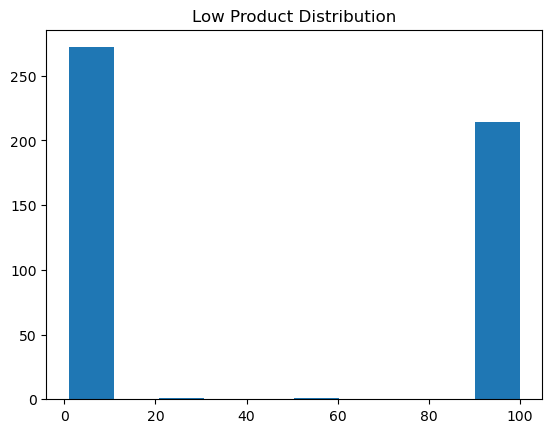

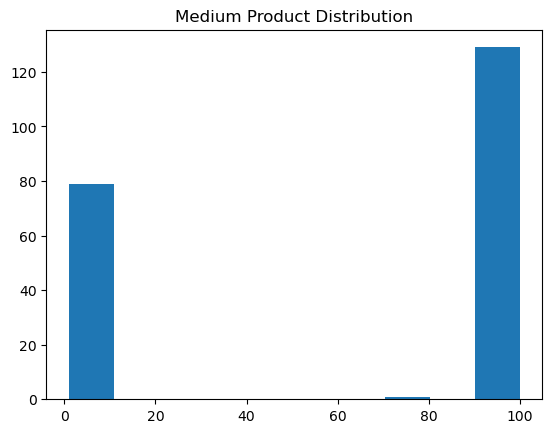

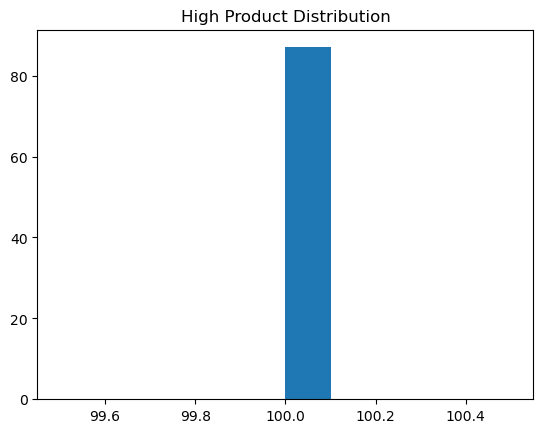

In [80]:
plt.hist(df_result[df_result["tool_wear"]=="L"]["number"])
plt.title("Low Product Distribution")
plt.show()
plt.hist(df_result[df_result["tool_wear"]=="M"]["number"])
plt.title("Medium Product Distribution")
plt.show()
plt.hist(df_result[df_result["tool_wear"]=="H"]["number"])
plt.title("High Product Distribution")
plt.show()